In [1]:
%reload_ext autoreload
%autoreload 2

from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor
from collections import OrderedDict
import numpy as np
import re
import h5py
from functools import partial
from itertools import product

from calibration import Display


# Wokflow

* General set up (Tab 0):
   
   - Module Number: Specify channel/module numbers that you want to analyse. Must be comma separated.
   - Pulse indices: Pulses that have x-rays. You can provide a range (start:stop:step) or comma separated (1,3,4 etc) or combination of range and individual pulses (1:10:2, 11, 14, 16 etc)
   - Region of interest (ROI x) in x for each module: Only range based (start:stop)
   - Region of interest (ROI y) in y for each module: Only range based (start:stop)
   
* Dark Run (Tab 1):
    
    - Dark Run Folder: (str) /gpfs/exfel/exp/MID/201931/proposal/raw/run_number
    - Train ids: Train indices to take average over. Range based (start:stop). Deafult is all train (:)
    - Process Darak button: To evalute average. This is done in parallel over modules. Doesn't block
      further analysis. Once results (average image and histograms) are available it be displayed automatically.
    - Using Pulses (slider) and module numbers (dropbox) on top one can visulaize data for each pulses or modules.

* Data Visualization (Tab 2):
    
    - Run Folder: (str) /gpfs/exfel/exp/MID/201931/proposal/raw/run_number
    - Train ids: Train indices. Range based (start:stop). Use cautiosly. It loads all train data in memory.
    Also processing is parallized over modules, therefore maximum pickle size has to be respected.
    
    - Subtract Dark. Once dark average data is available you will be able to check on subtract dark.
    - Load Run: Once things are set up, load the run.
    
    - Fitting Procedure:
    
        - First chose some reasonable peak threshold to filter out number of peaks
        - Chose peak distance to remove very close peaks,
        - Once peaks are chosen, one can click on button Fit Histogram to fit Gaussians. Number of peaks define the number of gaussian functions that will be used to fit the histogram. Generally fitting with 3-4 peaks give reasonable fitting 

In [ ]:
config = dict(
    dark_run_folder='/gpfs/exfel/exp/MID/201931/p900091/raw/r0504',
    run_folder='/gpfs/exfel/exp/MID/201931/p900091/raw/r0491',
)

## Widgets Display

In [ ]:
d = Display(config=config)
d.control_panel()

# Analysis without GUI



In [2]:
from functools import partial
import numpy as np
import plotly.graph_objs as go
from plotly.subplots import make_subplots

from scipy.ndimage import gaussian_filter, gaussian_filter1d
from scipy.signal import find_peaks

from calibration import DataProcessing, gauss_fit, eval_statistics
from karabo_data import by_index

    
    def DataProcessing(module_number, path, *,
                       train_index=None, pulse_ids=None,
                       rois=None, operation=None,
                       dark_run=None):
                   
           """ Process Data

                    Parameters
                    ----------
                    module_number: int
                        Channel number between 0, 15
                    path: str
                        Path to Run folder
                    train_index: karabo_data (by_index)
                        Default (all trains by_index[:])
                    pulse_ids: str
                        For eg. ":" to select all pulses in a train
                                "start:stop:step" to select indices with certain step size
                                "1,2,3" comma separated pulse index to select specific pulses
                                "1,2,3, 5:10" mix of above two
                        Default: all pulses ":"
                    rois: karabo_data slice constructor by_index
                        Select ROI of image data. For eg. by_index[..., 0:128, 0:64]
                        See karabo_data method: `get_array`

                    operation: function
                        For eg. functools.partial(np.mean, axis=0) to take mean over trains
                    dark_run: ndarray
                        dark_data to subtract

                    Return
                    ------
                    out: ndarray
                        Shape:  operation -> (n_trains, n_pulses, ..., slow_scan, fast_scan)
                    """

# General Parameters

In [ ]:
module_number = 15
pulse_ids = "1:250:2"
rois = by_index[:, :]

# Dark Run average

In [ ]:
# parameters

dark_run_folder = "/gpfs/exfel/exp/MID/201931/p900091/raw/r0504"

dark_train_index = by_index[:]

# mean over train index 
operation = partial(np.mean, axis=0)


In [ ]:
dark_average = DataProcessing(
    module_number, 
    dark_run_folder,
    train_index=dark_train_index,
    pulse_ids=pulse_ids,
    rois=rois,
    operation=operation)

print(dark_average.shape)

In [ ]:
# Write dark data to file that can be used later

dark_run = {module_number:dark_average}

with h5py.File("dark_run.h5", "w") as f:
    for modno, data in dark_run.items():
        g = f.create_group(f"entry_1/instrument/module_{modno}")
        g.create_dataset('data', data=dark_run[modno])

# Subtract Dark from a run

In [ ]:

run_folder = "/gpfs/exfel/exp/MID/201931/p900091/raw/r0491"

proc_train_index = by_index[250:280]



In [ ]:
dark_subtracted = DataProcessing(
    module_number, 
    run_folder,
    train_index=proc_train_index,
    pulse_ids=pulse_ids,
    rois=rois,
    dark_run=dark_average)

In [ ]:
# n_trains, pulses, gain_bits, slow_scan, fast_scan
print(f"Shape of Dark Subtracted Data: {dark_subtracted.shape}")

In [ ]:
dark_sub_run = {module_number:dark_subtracted}

with h5py.File("dark_subtracted.h5", "w") as f:
    for modno, data in dark_sub_run.items():
        g = f.create_group(f"entry_1/instrument/module_{modno}")
        g.create_dataset('data', data=dark_sub_run[modno])

# Visualization 

In [ ]:
# Create Empty Plots

import ipywidgets as widget

image_widget = go.FigureWidget(data=go.Heatmap(showscale=False))

trace = [go.Bar(), go.Scatter(mode='markers'), go.Scatter(mode='lines')]
hist_widget = go.FigureWidget(data=trace)

image_widget.layout.update(margin=dict(l=0, b=40, t=50), width=450)
hist_widget.layout.update(margin=dict(r=0, l=10, b=40, t=50), width=450)

display(widget.HBox([image_widget, hist_widget]))


In [ ]:
# Clear plots
hist_widget.data[1].x = []
hist_widget.data[1].y = []
hist_widget.data[2].x = []
hist_widget.data[2].y = []


# Pulse index to visualize
pulse_id = 11

# Mean image over trains (In this case 30 trains)
image_widget.data[0].z = np.mean(dark_subtracted[:, pulse_id, 0, ...], axis=0)

# Evaluate histogram
bin_centers, bin_counts = eval_statistics(dark_subtracted[:, pulse_id, 0, ...], bins=500)

# Update histogram image

hist_widget.data[0].x = bin_centers
hist_widget.data[0].y = bin_counts


# Fitting dark subtracted data

 

###   Peak finding to estimate intial fit parameters
    
    * Apply Gaussian filter to smooth out the histogram
    * Evaluate peaks for this filtered data
        - Peaks parameters: height, distance

In [ ]:
peak_threshold = 1000
peak_distance = 10

# Apply Gaussian filter
filtered = gaussian_filter(bin_counts, 1.5)

# Evaluate peaks
peaks, _ = find_peaks(filtered,
                      height=peak_threshold,
                      distance=peak_distance)

#Plot peaks and Gaussian filtered curve. 

hist_widget.data[1].x = bin_centers[peaks]
hist_widget.data[1].y = filtered[peaks]

hist_widget.data[2].x = bin_centers
hist_widget.data[2].y = filtered


print(f"Number of peaks: {len(peaks)}")
print(f"Peak positions, amplitudes: {list(zip(bin_centers[peaks], filtered[peaks]))}")

hist_widget

### Fit Gaussian

    * Number of peaks will decide number of Gaussians to fit data
    
        def gauss_fit(xdata, ydata, params):
            """
            Parameters
            ----------
            xdata: 1d array
            ydata: 1d array
            params: list
                [A1, A2, A3, ..., S1, S2, S3, ..., P1, P2, P3...]
                A: Amplitude of Gaussian
                S: Width of Gaussian
                P: Centre of Gaussian
                
            Return
            ------
            fit_data: 1d array
            popt: fit params
            perr: np.sqrt(np.diag(pcov))
                standard error in fit params

            """
    

In [ ]:
# Construct initial fit params list
params = []

params.extend(filtered[peaks])                         # Extend Amplitudes [A1, A2, A3, ...]
params.extend(np.full((len(bin_centers[peaks])), 10))  # Extend Sigma [S1, S2, S3, ...]
params.extend(bin_centers[peaks])                      # Extend Positions [P1, P2, P3, ...]

try:
    fit_data, popt, perr = gauss_fit(bin_centers, filtered, params)
    # Plot
    hist_widget.data[2].x = bin_centers
    hist_widget.data[2].y = fit_data
except Exception as ex:
    print(ex)

hist_widget

## Data Processing Parallelized over modules

In [ ]:
list_modules = [12, 13, 15]


In [ ]:

dark_average = partial(
    DataProcessing,
    path=dark_run_folder,
    pulse_ids="1:250:2",
    train_index=by_index[:],
    rois=by_index[..., :, :],
    operation=partial(np.mean, axis=0))


futures = OrderedDict()

with ProcessPoolExecutor(max_workers=len(list_modules)) as executor:
    ret = executor.map(dark_average, list_modules)

for data in ret:
    print(data.shape)

## Benchmarking IMINUIT

In [13]:
from iminuit import Minuit
from iminuit import minimize
from scipy.optimize import curve_fit


In [14]:
with h5py.File("dark_subtracted.h5", "r") as f:
    data_dark_sub = np.moveaxis(f["entry_1/instrument/module_15/data"][:], 0, 1)


print(data_dark_sub.shape)


(125, 30, 2, 512, 128)


In [80]:
bins = 1000
peak_threshold = 1000
peak_distance = 20

centers, counts = eval_statistics(data_dark_sub[0, :, 0, ...], bins=bins)

filtered = gaussian_filter(counts, 2.5)
filtered = counts
# Evaluate peaks
peaks, _ = find_peaks(filtered,
                      height=peak_threshold,
                      distance=peak_distance)



<IPython.core.display.Javascript object>


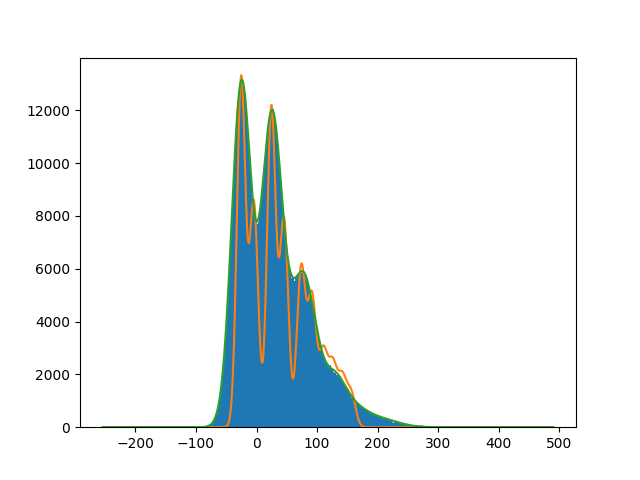

209299.9699527195


In [89]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
%matplotlib notebook


def gaussian(x, *params):
    num_gaussians = int(len(params) / 3)
    A = params[:num_gaussians]
    w = params[num_gaussians:2*num_gaussians]
    c = params[2*num_gaussians:3*num_gaussians]
    y = sum(
        [A[i]*np.exp(-(x-c[i])**2./(w[i])) for i in range(num_gaussians)])
    
    return y

def least_squares_np(xdata, ydata,  params):  
    yvar = 0.01
    y = gaussian(xdata, *params) 
    
    return np.sum((ydata - y) ** 2 / yvar)


least_sq = partial(
    least_squares_np, centers, filtered)

# limits = ((0, None), (0, None), (0, None), 
#           (0, None), (0, None), (0, None),
#           (None, None), (None, None), (None, None))

# Construct initial fit params list
params = []

params.extend(filtered[peaks])                          # Extend Amplitudes [A1, A2, A3, ...]
params.extend(np.full((len(centers[peaks])), 100))      # Extend Sigma [S1, S2, S3, ...]
params.extend(centers[peaks])                           # Extend Positions [P1, P2, P3, ...]

popt = params
try:
    popt, _ = curve_fit(gaussian, centers, filtered, p0=params)
except Exception as ex:
    pass

m = Minuit.from_array_func(least_sq, params, error=0.1, errordef=1)

m.migrad()


fig, ax = plt.subplots()
ax.hist(data_dark_sub[0, :, 0, ...].ravel(), bins=bins)
ax.plot(centers, gaussian(centers, *popt))
ax.plot(centers, gaussian(centers, *m.np_values()))

print(m.fval / (len(filtered) - len(params) )  )